
# Google Cluster Data — Colab EDA (Auto-Download)

This notebook is designed for **Google Colab**. It will:
- Create a workspace under `/content/google_cluster_data`
- **Download** the 2019 Google Cluster Data schema and a small sample of `task_usage`
- **Decompress** the sample
- Run first-pass EDA geared toward **cloud autoscaling**

> Tip: If you want files to persist, mount Google Drive in the next cell.


In [73]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project="rl-semester-project")


This is the schema foe instance_usage

In [71]:
from google.cloud import bigquery
client = bigquery.Client()

public_proj = "google.com:google-cluster-data"
dataset     = "clusterdata_2019_a"
table       = "instance_usage"

schema_df = client.query(f"""
SELECT column_name, data_type
FROM `{public_proj}.{dataset}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{table}'
ORDER BY ordinal_position
""").to_dataframe()

schema_df


,column_name,data_type
0,start_time,INT64
1,end_time,INT64
2,collection_id,INT64
3,instance_index,INT64
4,machine_id,INT64
5,alloc_collection_id,INT64
6,alloc_instance_index,INT64
7,collection_type,INT64
8,average_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"
9,maximum_usage,"STRUCT<cpus FLOAT64, memory FLOAT64>"


Aggregate CPU and memory load from instance_usage:

In [74]:
sql = """
SELECT
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(start_time), MINUTE) AS time_window,
  AVG(average_usage.cpus) AS avg_cpu,
  AVG(average_usage.memory) AS avg_mem,
  COUNT(DISTINCT machine_id) AS active_machines
FROM `google.com:google-cluster-data.clusterdata_2019_a.instance_usage`
GROUP BY time_window
ORDER BY time_window
LIMIT 10000
"""
df_usage = client.query(sql).to_dataframe()
df_usage.head()


,time_window,avg_cpu,avg_mem,active_machines
0,1970-01-01 00:05:00+00:00,0.006623,0.004912,9525
1,1970-01-01 00:06:00+00:00,0.003254,0.002733,3805
2,1970-01-01 00:07:00+00:00,0.003070,0.002770,4167
3,1970-01-01 00:08:00+00:00,0.001950,0.001823,4338
4,1970-01-01 00:09:00+00:00,0.001689,0.001468,5545


In [77]:
from google.cloud import bigquery
client = bigquery.Client()

PUBLIC = "google.com:google-cluster-data"
SHARD  = "clusterdata_2019_a"   # change to b..h as needed

schema = client.query(f"""
SELECT column_name, data_type
FROM `{PUBLIC}.{SHARD}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'machine_events'
ORDER BY ordinal_position
""").to_dataframe()
schema


,column_name,data_type
0,time,INT64
1,machine_id,INT64
2,type,INT64
3,switch_id,STRING
4,capacity,"STRUCT<cpus FLOAT64, memory FLOAT64>"
5,platform_id,STRING
6,missing_data_reason,INT64


In [79]:
sql = f"""
SELECT
  TIMESTAMP_TRUNC(TIMESTAMP_MICROS(time), MINUTE) AS time_window,
  SUM(CASE WHEN type = 0 THEN 1 ELSE 0 END) AS adds,     -- 0:add
  SUM(CASE WHEN type = 1 THEN 1 ELSE 0 END) AS removes,  -- 1:remove
  SUM(CASE WHEN type = 2 THEN 1 ELSE 0 END) AS updates   -- 2:update
FROM `{PUBLIC}.{SHARD}.machine_events`
GROUP BY time_window
ORDER BY time_window
LIMIT 10000
"""
df_events = client.query(sql).to_dataframe()
df_events.head()



,time_window,adds,removes,updates
0,1970-01-01 00:00:00+00:00,0,9526,0
1,1970-01-01 00:10:00+00:00,0,0,1
2,1970-01-01 00:11:00+00:00,0,1,0
3,1970-01-01 00:12:00+00:00,0,1,0
4,1970-01-01 00:13:00+00:00,0,1,0


Below is time series dataframe of workload + scaling actions, ready for RL Processing

In [80]:
df = pd.merge(df_usage, df_events, on="time_window", how="inner")
df.head()


,time_window,avg_cpu,avg_mem,active_machines,adds,removes,updates
0,1970-01-01 00:10:00+00:00,0.006117,0.004735,9523,0,0,1
1,1970-01-01 00:11:00+00:00,0.002606,0.001722,5384,0,1,0
2,1970-01-01 00:12:00+00:00,0.002485,0.001563,4991,0,1,0
3,1970-01-01 00:13:00+00:00,0.002093,0.001225,4764,0,1,0
4,1970-01-01 00:14:00+00:00,0.002586,0.001503,5253,0,1,5


In [82]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5102 entries, 0 to 5101
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   time_window      5102 non-null   datetime64[us, UTC]
 1   avg_cpu          5102 non-null   float64            
 2   avg_mem          5102 non-null   float64            
 3   active_machines  5102 non-null   Int64              
 4   adds             5102 non-null   Int64              
 5   removes          5102 non-null   Int64              
 6   updates          5102 non-null   Int64              
dtypes: Int64(4), datetime64[us, UTC](1), float64(2)
memory usage: 299.1 KB


,avg_cpu,avg_mem,active_machines,adds,removes,updates
count,5102.000000,5102.000000,5102.0,5102.0,5102.0,5102.0
mean,0.003428,0.001982,6604.740494,0.0,1.465504,1.404155
std,0.001739,0.001363,1967.714287,0.0,1.763593,2.430231
min,0.000592,0.000305,2089.0,0.0,0.0,0.0
25%,0.002145,0.001050,5069.0,0.0,0.0,0.0
50%,0.002895,0.001440,6416.5,0.0,1.0,1.0
75%,0.004347,0.002214,7758.75,0.0,2.0,2.0
max,0.014657,0.012950,9845.0,0.0,20.0,52.0


In [88]:

print("Columns:", list(df.columns))
print("\nShape:", df.shape)
print("\nNull counts (top 20):\n", df.isna().sum().sort_values(ascending=False).head(20))
df.describe(include='all').T.head(20)


Columns: ['time_window', 'avg_cpu', 'avg_mem', 'active_machines', 'adds', 'removes', 'updates']

Shape: (5102, 7)

Null counts (top 20):
 time_window        0
avg_cpu            0
avg_mem            0
active_machines    0
adds               0
removes            0
updates            0
dtype: int64


,count,mean,min,25%,50%,75%,max,std
time_window,5102,1970-01-04 08:40:35.444923+00:00,1970-01-01 00:10:00+00:00,1970-01-02 16:23:15+00:00,1970-01-04 10:49:00+00:00,1970-01-05 22:39:45+00:00,1970-01-07 22:43:00+00:00,NaN
avg_cpu,5102.0,0.003428,0.000592,0.002145,0.002895,0.004347,0.014657,0.001739
avg_mem,5102.0,0.001982,0.000305,0.00105,0.00144,0.002214,0.01295,0.001363
active_machines,5102.0,6604.740494,2089.0,5069.0,6416.5,7758.75,9845.0,1967.714287
adds,5102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
removes,5102.0,1.465504,0.0,0.0,1.0,2.0,20.0,1.763593
updates,5102.0,1.404155,0.0,0.0,1.0,2.0,52.0,2.430231


##Correlation Matrix

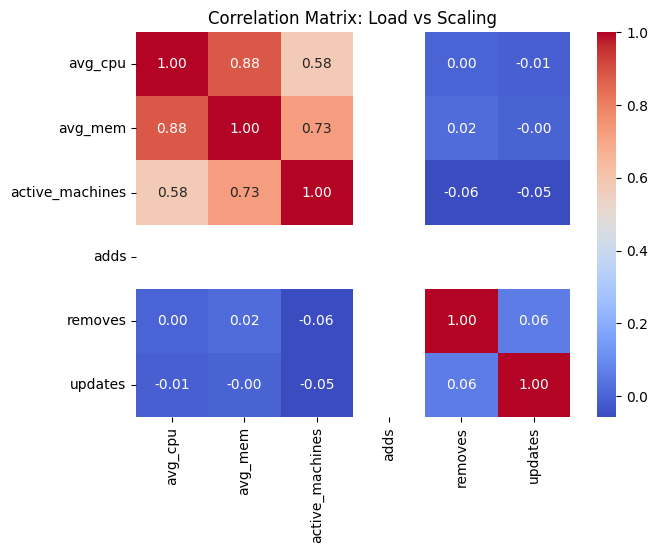

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['avg_cpu','avg_mem','active_machines','adds','removes','updates']].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Load vs Scaling")
plt.show()


##Visual Temporal Alignment

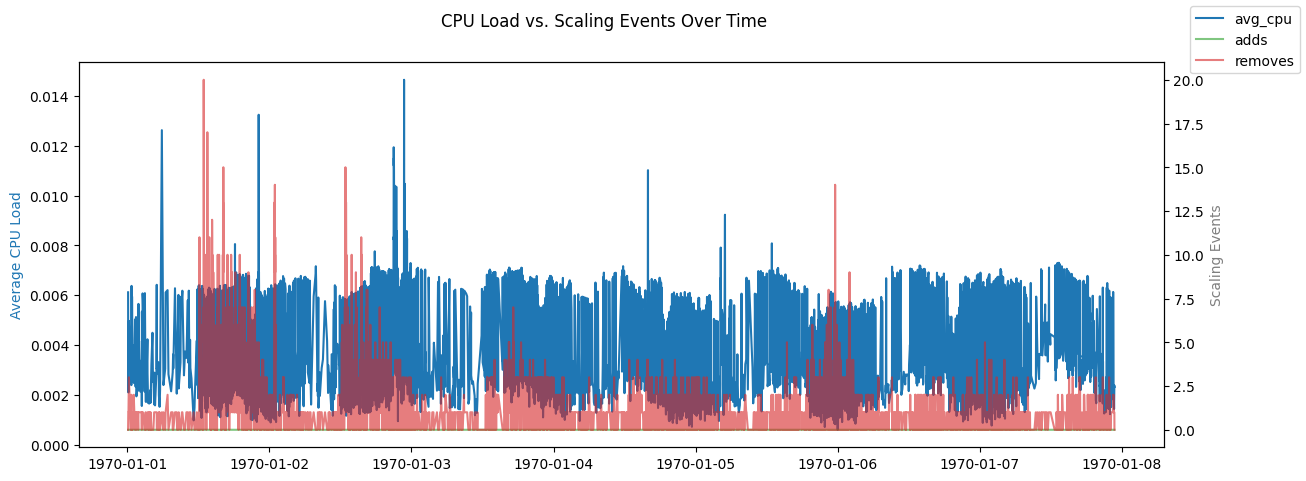

In [84]:
fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(df['time_window'], df['avg_cpu'], label='avg_cpu', color='tab:blue')
ax1.set_ylabel('Average CPU Load', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(df['time_window'], df['adds'], label='adds', color='tab:green', alpha=0.6)
ax2.plot(df['time_window'], df['removes'], label='removes', color='tab:red', alpha=0.6)
ax2.set_ylabel('Scaling Events', color='tab:gray')

fig.suptitle("CPU Load vs. Scaling Events Over Time")
fig.legend(loc='upper right')
plt.show()


##Lagged Correlation

In [91]:
import pandas as pd

def lag_corr(x, y, max_lag=5):
    results = []
    for lag in range(1, max_lag+1):
        corr = x.corr(y.shift(-lag))
        results.append({'lag': lag, 'corr': corr})
    return pd.DataFrame(results)

lag_corr(df['avg_cpu'], df['adds'], max_lag=10)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:292

,lag,corr
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN
5,6,NaN
6,7,NaN
7,8,NaN
8,9,NaN
9,10,NaN



## Basic Info & Nulls
